In [1]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import math
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

# Prepocessing
- Adding trip duration and datetime to datasets

In [2]:
# trn_fp = os.path.dirname("cse151B_project/data/train.csv")
train_raw = pd.read_csv("train.csv")
# tt_fp = os.path.dirname("cse151B_project/data/test_public.csv")
test_raw = pd.read_csv("test_public.csv")

In [3]:
def transform_raw(df, train):
    """
    adds polyline and datetime info to dataset
    
    df: raw df
    train: boolean on whether or not passed in df is train or test
    """
    def polyline_to_trip_duration(polyline):
        return max(polyline.count("[") - 2, 0) * 15
    
    df = df.copy()
    # Convert Unix timestamp to datetime
    df['DT'] = pd.to_datetime(df['TIMESTAMP'], unit='s')

    # Extract year, month, day of the week, and hour of the day
    df['YEAR'] = df['DT'].dt.year
    df['MONTH'] = df['DT'].dt.month
    df['WEEK'] = df['DT'].dt.dayofweek
    df['HOUR'] = df['DT'].dt.hour
    
    # extract ride duration for training set
    if (train):
        df["DURATION"] = df["POLYLINE"].apply(polyline_to_trip_duration)
    return df

In [27]:
train_set = transform_raw(train_raw, True)
duration_col = np.array(train_set['DURATION']).reshape(-1,1)

In [4]:
full_set = pd.concat((train_raw, test_raw))
full_set.shape

(1710990, 9)

In [5]:
full_set_proc = transform_raw(full_set, False)

In [6]:
full_set_proc

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DT,YEAR,MONTH,WEEK,HOUR
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 00:00:58,2013,7,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 00:08:23,2013,7,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 00:02:31,2013,7,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 00:00:54,2013,7,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 00:04:51,2013,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False,NaN,2014-12-21 14:18:05,2014,12,6,14
316,T324,B,NaN,53.0,20000020,1419170802,A,False,NaN,2014-12-21 14:06:42,2014,12,6,14
317,T325,C,NaN,NaN,20000207,1419172121,A,False,NaN,2014-12-21 14:28:41,2014,12,6,14
318,T326,A,76232.0,NaN,20000667,1419171980,A,False,NaN,2014-12-21 14:26:20,2014,12,6,14


# Finding Optimal Clusters
- ORIGIN_CALL, ORIGIN_STAND used in clustering to create meaningful features

In [7]:
# sample for finding clusters
sample_size = int(full_set_proc.shape[0] * 0.1)
sample = full_set_proc.sample(sample_size)

In [8]:
# feature engineering for clustering
def cluster_features(df, call_thresh, stand_thresh):
    """
    feature engineering for clustering
    
    df: output of transform raw
    call_thresh: min_frequency for ORIGIN_CALL
    stand_thresh: min_frequency for ORIGIN_STAND
    """
    call_transformer = OneHotEncoder(handle_unknown='ignore', min_frequency=call_thresh)
    stand_transformer = OneHotEncoder(handle_unknown='ignore', min_frequency=stand_thresh)
    
    prepoc = ColumnTransformer(
        transformers = [
            ("ohe_call", call_transformer, ["ORIGIN_CALL"]),
            ("ohe_stand", stand_transformer, ["ORIGIN_STAND"])
        ],
        remainder="drop"
    )
    
    return prepoc.fit_transform(df)

In [9]:
call_thresh = 0.0001
stand_thresh = 0.01
sample_proc = cluster_features(sample, call_thresh, stand_thresh)

In [10]:
sample_proc

<171099x121 sparse matrix of type '<class 'numpy.float64'>'
	with 342198 stored elements in Compressed Sparse Row format>

### Elbow Method 

In [11]:
def kmeans(data, k):
    """
    data: output of cluster_features
    """
    # Create the KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)

    # Get the cluster labels and centroids
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    wcss = kmeans.inertia_
    
    return centroids, wcss

In [12]:
centroids = []
wcss_list = []
for i in np.arange(5,35,5):
    cen, wc = kmeans(sample_proc, i)
    centroids.append(cen)
    wcss_list.append(wc)

/home/zsiyed/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 20 Clusters Optimal

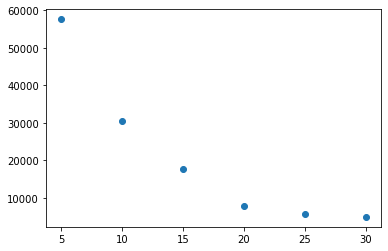

In [13]:
plt.scatter(np.arange(5,35,5), wcss_list)
plt.show()

### Adding Cluster to Training Data

In [14]:
proc = cluster_features(full_set, call_thresh, stand_thresh)

In [15]:
proc

<1710990x116 sparse matrix of type '<class 'numpy.float64'>'
	with 3421980 stored elements in Compressed Sparse Row format>

In [16]:
# Create the KMeans object and fit the data
kmeans = KMeans(n_clusters=15)
kmeans.fit(proc)

# Get the cluster labels and centroids
labels = kmeans.labels_

/home/zsiyed/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
full_set_labeled = full_set_proc.assign(
    CLUSTER=labels
)

In [18]:
full_set_labeled

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DT,YEAR,MONTH,WEEK,HOUR,CLUSTER
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 00:00:58,2013,7,0,0,2
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 00:08:23,2013,7,0,0,14
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 00:02:31,2013,7,0,0,2
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 00:00:54,2013,7,0,0,2
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 00:04:51,2013,7,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False,NaN,2014-12-21 14:18:05,2014,12,6,14,0
316,T324,B,NaN,53.0,20000020,1419170802,A,False,NaN,2014-12-21 14:06:42,2014,12,6,14,10
317,T325,C,NaN,NaN,20000207,1419172121,A,False,NaN,2014-12-21 14:28:41,2014,12,6,14,2
318,T326,A,76232.0,NaN,20000667,1419171980,A,False,NaN,2014-12-21 14:26:20,2014,12,6,14,0


# One Hot Encoding Full set

In [67]:
# OHE origin stand directly
stand_thresh2 = 0.005
stand_transformer = OneHotEncoder(handle_unknown='ignore', min_frequency=stand_thresh2)

stand = ColumnTransformer(
    transformers = [
        ("ohe_stand", stand_transformer, ["ORIGIN_STAND"])
    ],
    remainder="drop"
)

stand_OHE = stand.fit_transform(full_set_labeled)

In [68]:
stand_OHE.shape

(1710990, 31)

In [69]:
OHE = OneHotEncoder(handle_unknown='ignore', sparse = False)    
prepoc = ColumnTransformer(
    transformers = [
        ("OHE", OHE, ["CALL_TYPE", "YEAR", "MONTH", "WEEK", "HOUR", "CLUSTER"]),
    ],
    remainder="drop"
)

In [70]:
OHE_df = prepoc.fit_transform(full_set_labeled)

/home/zsiyed/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [71]:
OHE_df.shape

(1710990, 63)

In [72]:
full_ohe = np.concatenate((stand_OHE.todense(), OHE_df), axis = 1)
full_ohe.shape

(1710990, 94)

In [73]:
train = np.hstack((full_ohe[:train_raw.shape[0]], duration_col)) 
test = full_ohe[train_raw.shape[0]:]
print(train.shape, test.shape)

(1710670, 95) (320, 94)


In [74]:
np.save("processed_train_set", train)
np.save("processed_test_set", test)